### All Shapes and Colors - Kaggle Challenge ###

In [1]:
# Imports
import os, ast
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T
import matplotlib.pyplot as plt

# Device (prototyped on my MacBook Air M1)
device = torch.device(
    "mps" if torch.backends.mps.is_available() else
    ("cuda" if torch.cuda.is_available() else "cpu") # for colab compatibility
)
device

device(type='mps')

After looking at the problem, I can see we have the following constraints:
- Each image contains k objects where 1 <= k <= 9, since there are no duplicate objects with same (shape, color) in any given image.
- we can have multiple of the same shape and multiple of the same color in the image. 

I'll want to use a multi-label target over all 9 possible pairs. For each image, the target is a 9-dimension one-hot vector with a one for each present pair in the image.

In [2]:
SHAPES = ['circle', 'square', 'triangle']
COLORS = ['red', 'green', 'blue']

# assign each (shape, color) pair an index
PAIR_TO_IDX = {
    f"{shape}_{color}": i
    for i, (shape, color) in enumerate(
        (s, c) for s in SHAPES for c in COLORS
    )
}

IDX_TO_PAIR = {v: k for k, v in PAIR_TO_IDX.items()} # need this to decode predictions

print(PAIR_TO_IDX)
print(IDX_TO_PAIR)

{'circle_red': 0, 'circle_green': 1, 'circle_blue': 2, 'square_red': 3, 'square_green': 4, 'square_blue': 5, 'triangle_red': 6, 'triangle_green': 7, 'triangle_blue': 8}
{0: 'circle_red', 1: 'circle_green', 2: 'circle_blue', 3: 'square_red', 4: 'square_green', 5: 'square_blue', 6: 'triangle_red', 7: 'triangle_green', 8: 'triangle_blue'}


Step one is to setup label representation

In [3]:
# Encoding the pairs to multi-hot vector
def encode_pairs(pairs):
    """
    Encode a list of (shape, color) pairs to a multi-hot vector.
    pairs: list of tuples (shape, color)
    returns: torch tensor of shape (9,)
    """
    target = np.zeros(len(PAIR_TO_IDX), dtype=np.float32)
    for shape, color in pairs:
        shape, color = shape.lower(), color.lower()
        key = f"{shape}_{color}"
        y = PAIR_TO_IDX[key]
        target[y] = 1.0
    target = torch.from_numpy(target)
    return target

# pairs = [("circle","red"), ("triangle","blue")]
# y = encode_pairs(pairs)
# print(y)        
# print(y.sum())  

def decode_vec(y):
    """
    Decode a multi-hot vector to a list of (shape, color) pairs.
    y: torch tensor of shape (9,)
    returns: list of tuples (shape, color)
    """
    probs = torch.sigmoid(y) # convert logits to probabilities using sigmoid (will give values between 0 and 1)
    idxs = (probs >= 0.5).nonzero(as_tuple=True)[0].tolist() # threshold at 0.5
    pairs = []
    for i in idxs:
        pair = IDX_TO_PAIR[i]
        shape, color = pair.split("_")
        pairs.append((shape, color))
    return pairs


# logits = torch.tensor([3.0, -1.0, 0.2, 0.0, 0.0, 2.5, -2.0, 0.0, 0.0])
# decoded = decode_vec(logits)
# print(decoded)



There's a function to make the data usable for training. I represent the labels as the 9-dim tensor mentioned earlier. 

I also have a function to decode the tensor outputted at inference time. It applies a sigmoid to get probabilities, thresholds, then turns the tensor back into (shape, color) tuples. 

Next thing to do is load the data.

In [4]:
def parse_label_string(string): # need this since the CSV has labels as strings
    """
    Parse a label string into a list of (shape, color) pairs.
    string: str, e.g. "[(circle_red), (triangle_blue)]" or "[]"
    returns: list of tuples (shape, color)
    """
    if string == "" or string == "[]" or string is None: #handle null or empty arg
        return []
    s = string.lower().strip()
    data = ast.literal_eval(s) # turn the string into a list of tuples
    # normalize the tuples
    data = [(shape.strip().lower(), color.strip().lower()) for shape, color in data]
    return data

# test parser
# samples = [
#     "[('square', 'blue'), ('circle', 'green'), ('square', 'red')]",
#     "[('circle','blue'),('square','green'),('circle','red'),('square','red')]",
#     "[]"
# ]
# for s in samples:
#     pairs = parse_label_string(s)
#     assert isinstance(pairs, list), "Parser should return a list"
#     for (shape, color) in pairs:
#         assert shape in SHAPES and color in COLORS, f"Bad pair parsed: {(shape,color)}"

Creating dataset classes here. I use pillow to load the images and apply transformations. In this case I'm just doing normalization since the provided images already look like they have distortion and noise applied. No resizing either. I may add image augmentation if validation suggests any overfitting.

In [ ]:
# Datasets
class ShapesColorsDatasetTrain(Dataset):
    """
    Dataset for training and validation: (image_tensor, target_vector)
    CSV columns: image_path, label
    """
    def __init__(self, csv_file, img_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # resolve image path
        rel = str(row["image_path"])
        img_path = rel if os.path.isabs(rel) else os.path.join(self.img_dir, rel)

        # load image with pillow and force rgb color space
        img = Image.open(img_path).convert("RGB")

        # apply any preprocessing transforms
        if self.transform:
            img = self.transform(img)

        # parse and encode label
        pairs = parse_label_string(row["label"])    
        target = encode_pairs(pairs)                    

        # return tensors ready for the model and loss
        return img, target
    
class ShapesColorsDatasetTest(Dataset):
    """
    Dataset for testing: (image_tensor, image_path)
    CSV column: image_path
    """
    def __init__(self, csv_file, img_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        rel = str(self.df.iloc[idx]["image_path"])
        img_path = rel if os.path.isabs(rel) else os.path.join(self.img_dir, rel)

        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        return img, rel
    
# Create datasets using existing classes with index subsets
class IndexedDataset(Dataset):
    def __init__(self, base_dataset, indices):
        self.base_dataset = base_dataset
        self.indices = indices
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        return self.base_dataset[self.indices[idx]]

Transforms and loaders. I'm using a batch size of 32, shuffling for training, and numworkers = 2. I set numworkers to 0 while working on my Mac, but I'll bring those back if I move to a Colab env. Seems like this dataset is small enough that my M1 should be okay.

Total training samples: 5000
Train split: 4000, Val split: 1000
Datasets created - Train: 4000, Val: 1000, Test: 1000


/Users/omediratta/miniconda3/envs/kodiak_kaggle_vision/lib/python3.9/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


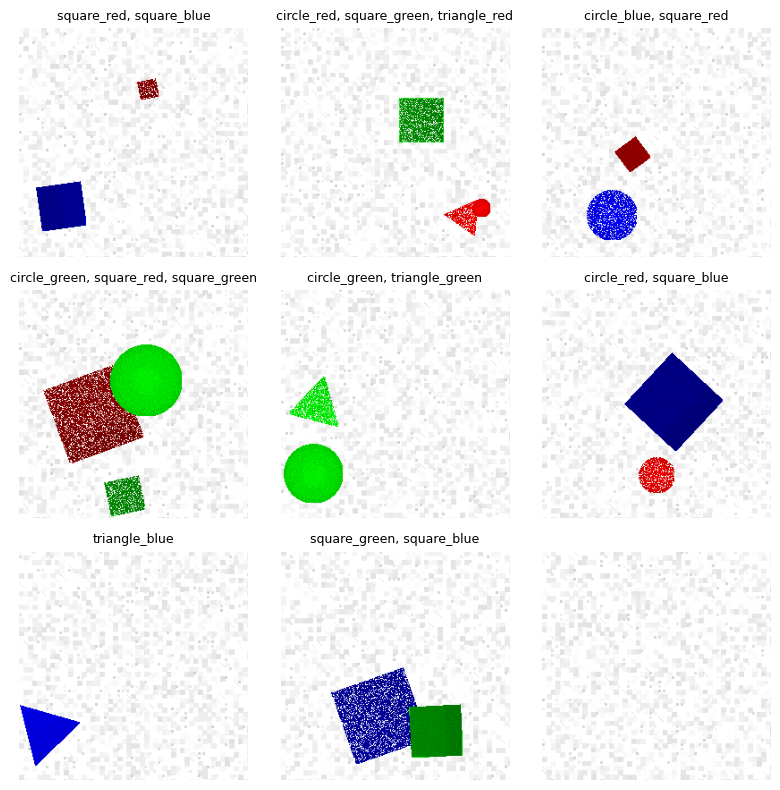

In [ ]:
BATCH_SIZE = 32

# File paths 
train_csv = "all-shapes-and-colors-v-2/dataset_v3/train.csv"
test_csv = "all-shapes-and-colors-v-2/dataset_v3/test.csv"
train_img_dir = "all-shapes-and-colors-v-2/dataset_v3"  
test_img_dir = "all-shapes-and-colors-v-2/dataset_v3"   

# Load and split training data
train_df = pd.read_csv(train_csv)
np.random.seed(17)
indices = np.random.permutation(len(train_df))
split_idx = int(0.8 * len(indices)) # 80 20 split ratio for the training and validation sets
train_indices, val_indices = indices[:split_idx], indices[split_idx:]

print(f"Total training samples: {len(train_df)}")
print(f"Train split: {len(train_indices)}, Val split: {len(val_indices)}")

# Transforms
train_tfms = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
val_tfms = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create base training dataset and split it
full_train_ds = ShapesColorsDatasetTrain(train_csv, train_img_dir, transform=train_tfms)
train_ds = IndexedDataset(full_train_ds, train_indices)

full_val_ds = ShapesColorsDatasetTrain(train_csv, train_img_dir, transform=val_tfms) 
val_ds = IndexedDataset(full_val_ds, val_indices)

test_ds = ShapesColorsDatasetTest(test_csv, test_img_dir, transform=val_tfms)

# Create DataLoaders
train_loader = DataLoader(
    train_ds, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=0, 
    pin_memory=True
)
val_loader = DataLoader(
    val_ds, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=0, 
    pin_memory=True
)
test_loader = DataLoader(
    test_ds, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=0, 
    pin_memory=True
)

print(f"Datasets created - Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

#test the dataset
# x0, y0 = train_ds[0]
# print("image:", x0.shape)         
# print("target:", y0)              
# print("num objects:", int(y0.sum().item()))

def unnorm(x):
    # invert Normalize(mean=0.5, std=0.5) -> back to [0,1] for display
    return (x * 0.5 + 0.5).clamp(0, 1)

images, targets = next(iter(train_loader))

plt.figure(figsize=(8, 8))
for i in range(min(9, images.size(0))):
    plt.subplot(3, 3, i+1)
    img = unnorm(images[i]).permute(1, 2, 0).numpy()
    plt.imshow(img)
    idxs = (targets[i] > 0.5).nonzero(as_tuple=True)[0].tolist()
    labels = [IDX_TO_PAIR[j] for j in idxs]  # e.g., 'triangle_blue'
    plt.title(", ".join(labels), fontsize=9)
    plt.axis("off")
plt.tight_layout(); plt.show()